In [1]:
# from preproc_tools import get_fr_by_sample, to_python_hdf5
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from pathlib import Path
import h5py
from sklearn.svm import SVC
from scipy.spatial.distance import pdist
import pickle
import pandas as pd
from datetime import datetime
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import  select_trials
from ephysvibe.trials.spikes import firing_rate
from typing import Dict, List
seed=1997

In [2]:
def check_number_of_trials(xdict,samples,min_ntr):
    for key in samples:
        if xdict[key].shape[0]<min_ntr:
            return False
    return True

In [14]:
pred_names={'color':['c1','c5'],'orient':['o1','o5'],'sampleid':['11','15','51','55'],'neutral':['n','nn']}

In [3]:
def color_data(fr_samples:Dict,min_ntr:int):
    samples = ['11','15','51','55']
    enough_tr = check_number_of_trials(fr_samples,samples,min_ntr)
    if not enough_tr: return None
    c1 = np.concatenate([fr_samples['11'],fr_samples['51']],axis=0)
    c5 = np.concatenate([fr_samples['15'],fr_samples['55']],axis=0)
    color = {'c1':c1,'c5':c5}
    return color

def orient_data(fr_samples:Dict,min_ntr:int):
    samples = ['11','15','51','55']
    enough_tr = check_number_of_trials(fr_samples,samples,min_ntr)
    if not enough_tr: return None
    o1 = np.concatenate([fr_samples['11'],fr_samples['15']],axis=0)
    o5 = np.concatenate([fr_samples['51'],fr_samples['55']],axis=0)
    orient = {'o1':o1,'o5':o5}
    return orient

def sampleid_data(fr_samples:Dict,min_ntr:int):
    samples = ['11','15','51','55']
    enough_tr = check_number_of_trials(fr_samples,samples,min_ntr)
    if not enough_tr: return None
    return fr_samples

def neutral_data(fr_samples:Dict,min_ntr:int):
    samples = ['0','11','15','51','55']
    enough_tr = check_number_of_trials(fr_samples,samples,min_ntr)
    if not enough_tr: return None
    n = fr_samples['0']
    nn = np.concatenate([fr_samples['11'],fr_samples['15'],fr_samples['51'],fr_samples['55']],axis=0)
    neutral = {'n':n,'nn':nn}
    return neutral

In [4]:
def preproc_for_decoding(neu:NeuronData,params:Dict,to_decode:str,min_ntr:int,start_sample:int,end_sample:int,start_test:int,end_test:int,avgwin:int=100,step:int=10,zscore=True):
    # Average fr across time
    idx_start_sample = int((getattr(neu,params['time_before_son'])  + start_sample)/step)
    idx_end_sample = int((getattr(neu,params['time_before_son'])  + end_sample)/step)
    idx_start_test = int((getattr(neu,params['time_before_t1on']) + start_test)/step)
    idx_end_test = int((getattr(neu,params['time_before_t1on']) + end_test)/step)
    sampleon=getattr(neu,params['sampleon'])
    t1on=getattr(neu,params['t1on'])

    fr_son = firing_rate.moving_average(
            sampleon, win=avgwin, step=step
        )[:, idx_start_sample:idx_end_sample]
    fr_t1on = firing_rate.moving_average(
            t1on, win=avgwin, step=step
        )[:, idx_start_test:idx_end_test]

    fr = np.concatenate([fr_son,fr_t1on],axis=1)
    if zscore:
        fr_std = np.std(fr, ddof=1, axis=0)
        fr_std = np.where(fr_std == 0, 1, fr_std)
        fr = (fr - np.mean(fr, axis=0).reshape(1, -1)) / fr_std.reshape(1, -1)

    fr_samples = select_trials.get_sp_by_sample(fr, neu.sample_id[getattr(neu,params['maskson'])])

    if to_decode == 'color':
        data = color_data(fr_samples,min_ntr)
    elif to_decode == 'orient':
        data = orient_data(fr_samples,min_ntr)
    elif to_decode == 'sampleid':
        data = sampleid_data(fr_samples,min_ntr)
    elif to_decode == 'neutral':
        data = neutral_data(fr_samples,min_ntr)
    return data

In [5]:
def pick_train_test_trials(idx_trials, train_ratio,rng):
    n_trials = len(idx_trials)
    tmp = rng.permutation(idx_trials)
    train = tmp[: int((n_trials * train_ratio))]
    test = tmp[int((n_trials * train_ratio)) :]
    return train, test

In [19]:
pred_names[to_decode]

['o1', 'o5']

In [20]:
def compute_decoding(model,list_data,trial_duration,ntr_train,ntr_test,to_decode,seed):
    rng = np.random.default_rng(seed)
    test_train_ratio = 1 - ntr_test / ntr_train
    topred=pred_names[to_decode]
    ntopred = len(topred)
    num_cells=len(list_data)
    # Initialize arrays to store train and test data
    data_train = np.empty(
        [trial_duration, ntr_train*ntopred, num_cells]
    )
    data_test = np.empty(
        [trial_duration, ntr_test*ntopred, num_cells]
    )
    perf = np.empty([trial_duration, trial_duration])
    y_train,y_test = [],[]
    for i in range(ntopred):
        y_train.append(np.zeros(ntr_train)+i)
        y_test.append(np.zeros(ntr_test)+i) 
    y_train,y_test = np.concatenate(y_train),np.concatenate(y_test)

    # Iterate through neurons to randomly pick trials
    for icell,cell in enumerate(list_data):
        trials_train,trials_test=[],[]
        for ipred in topred:
            trials = cell[ipred]
            idx_trials = np.arange(len(trials))
            train, test = pick_train_test_trials(idx_trials, test_train_ratio,rng)
            train = rng.choice(train, ntr_train, replace=True)
            test = rng.choice(test, ntr_test, replace=True)
            trials_train.append(trials[train])
            trials_test.append(trials[test])

        # build matrices of  [timestamp, trials, neurons] dimensions to feed to classifiers
        data_train[:, :, icell] = np.concatenate(trials_train,axis=0).T
        data_test[:, :, icell] = np.concatenate(trials_test,axis=0).T
    
    # train and test classifier
    for time_train in range(trial_duration):
        model.fit(data_train[time_train], y_train)
        for time_test in range(trial_duration):
            y_predict = model.predict(data_test[time_test])
            perf[time_train, time_test] = np.where(y_predict - y_test == 0)[0].shape[0]/(ntr_test*ntopred)
    
    return perf

### Prepeare data for decoding

In [15]:
# define vars
to_decode='orient'
ntr_train = 30
ntr_test = 10
min_ntr = 25
start_sample=-200
end_sample=850
start_test=-400
end_test=450
step = 10
trial_duration =int(((end_sample-start_sample)+(end_test-start_test))/step)
path=""
params= {
        'time_before_son': 'time_before_son_in',
        'time_before_t1on': 'time_before_t1on_in',
        'sampleon': 'sp_son_in',
        't1on': 'sp_t1on_in',
        'maskson': 'mask_son_in'
}
# preprocessing 
popu = PopulationData.from_python_hdf5('test.h5')
# split by condition and check enough number of trials (>25)
list_data = popu.execute_function(preproc_for_decoding,params,to_decode,min_ntr,start_sample,end_sample,start_test,end_test,avgwin=100,ret_df=False)
list_data = [idata for idata in list_data if idata is not None ]

100%|██████████| 530/530 [00:15<00:00, 33.25it/s]


### Decode

In [22]:
niterations = 10
# pick random trials for training and testing and iterate with a double for to train and test in all t
model = SVC(
    kernel="linear", C=0.8, decision_function_shape="ovr", gamma="auto", degree=1
)
rng = np.random.default_rng(seed)
seeds = rng.choice(np.arange(0,3000), size=niterations, replace=False)
all_perf = Parallel(n_jobs=20)(delayed(compute_decoding)(model,list_data,trial_duration,ntr_train,ntr_test,to_decode,seeds[it]) for it in tqdm(range(niterations)))

100%|██████████| 10/10 [00:00<00:00, 1178.18it/s]


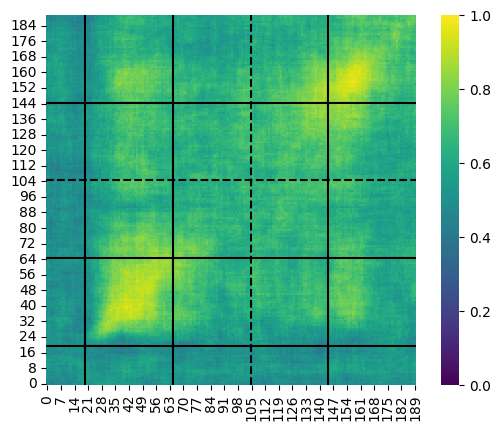

In [23]:
f,ax=plt.subplots()
sns.heatmap(np.mean(all_perf,axis=0),ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'k')
ax.hlines([20,65],0,190,'k')
ax.vlines([105],0,190,'k','--')
ax.hlines([105],0,190,'k','--')
ax.vlines([145],0,190,'k')
ax.hlines([145],0,190,'k')

In [10]:
all_perf

[array([[0.55, 0.5 , 0.5 , ..., 0.6 , 0.55, 0.5 ],
        [0.55, 0.45, 0.45, ..., 0.6 , 0.55, 0.45],
        [0.6 , 0.45, 0.45, ..., 0.6 , 0.55, 0.5 ],
        ...,
        [0.45, 0.45, 0.5 , ..., 1.  , 1.  , 1.  ],
        [0.45, 0.45, 0.45, ..., 1.  , 1.  , 1.  ],
        [0.45, 0.45, 0.45, ..., 1.  , 1.  , 1.  ]]),
 array([[0.4 , 0.5 , 0.55, ..., 0.6 , 0.6 , 0.6 ],
        [0.4 , 0.5 , 0.55, ..., 0.65, 0.55, 0.45],
        [0.4 , 0.5 , 0.55, ..., 0.6 , 0.5 , 0.5 ],
        ...,
        [0.5 , 0.5 , 0.5 , ..., 1.  , 1.  , 1.  ],
        [0.5 , 0.5 , 0.5 , ..., 1.  , 1.  , 1.  ],
        [0.5 , 0.45, 0.5 , ..., 1.  , 1.  , 1.  ]]),
 array([[0.4 , 0.6 , 0.45, ..., 0.6 , 0.4 , 0.55],
        [0.45, 0.55, 0.55, ..., 0.65, 0.6 , 0.55],
        [0.45, 0.5 , 0.55, ..., 0.6 , 0.55, 0.6 ],
        ...,
        [0.5 , 0.5 , 0.5 , ..., 1.  , 1.  , 1.  ],
        [0.5 , 0.5 , 0.5 , ..., 1.  , 1.  , 1.  ],
        [0.5 , 0.5 , 0.5 , ..., 1.  , 1.  , 1.  ]]),
 array([[0.65, 0.65, 0.65, ..., 0.5 ,